In [18]:
import os
import json
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

from data_utils import get_df_from_json, get_consolidated_dataframe

### Dataset analysis
We first analyse the composition of the given dataset. We have pairs of audio .wav files with the corresponding annotations in JSON format. Let's take a look at these annotations:

In [4]:
json_path = '/home/virgile/data/vad_data/1246-124548-0018.json'
target = json.load(open(json_path, 'r'))
print(json.dumps(target['speech_segments'][0:3], indent=4))

[
    {
        "start_time": 0.21,
        "end_time": 0.42
    },
    {
        "start_time": 0.42,
        "end_time": 0.71
    },
    {
        "start_time": 0.71,
        "end_time": 1.1099999999999999
    }
]


Annotations are timings in seconds corresponding to speech segments in the audio file.
We need to clean and aggregate this data in order to have statistics over the dataset. 
For this, we code a function `get_df_from_json` that will give us utterances time for both speech and non-speech segments.

In [9]:
df = get_df_from_json(json_path)
df.head()

,start_time,end_time,utt_time,speech,audio_id
0,0.00,0.21,0.21,0.0,/home/virgile/data/vad_data/1246-124548-0018.wav
1,0.21,0.42,0.21,1.0,/home/virgile/data/vad_data/1246-124548-0018.wav
2,0.42,0.71,0.29,1.0,/home/virgile/data/vad_data/1246-124548-0018.wav
3,0.71,1.11,0.40,1.0,/home/virgile/data/vad_data/1246-124548-0018.wav
4,1.11,1.61,0.50,1.0,/home/virgile/data/vad_data/1246-124548-0018.wav


Let's aggregate this data over the whole dataset : 

In [10]:
speech_df = get_consolidated_dataframe(json_data_path='/home/virgile/data/vad_data/')

100%|██████████| 957/957 [00:28<00:00, 34.00it/s]


As we deal with a binary classification problem, we need to know if our dataset is well balanced, meaning we have the same amount of speech time than non-speech time

In [11]:
print("Total time of speech (s): ", speech_df[speech_df['speech']==1].utt_time.sum())
print("Total time of non speech (s): ", speech_df[speech_df['speech']==0].utt_time.sum())


Total time of speech (s):  9519.91
Total time of non speech (s):  1984.3899999999999


The dataset is highly unbalanced. 
We either need to provide new samples containing non-speech noise, or delete some of speech data to our existing signals.
As suggested by the paper I am following, I decided to provide more non-speech data.

### Non-speech noise samples creation

To get new noise samples, I decided to use LibriSpeech signals together with an energy-based VAD implementation found on the web, in Python.
As a relatively "clean" dataset, this signal-based VAD can retrieve easily with not much error the non-speech part of the signal. We can then extract them trackwise to contruct new samples

No handles with labels found to put in legend.


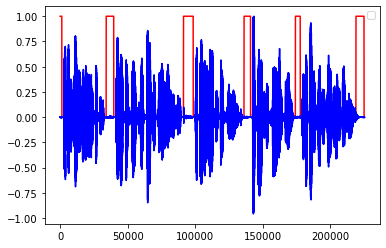

In [5]:
from energy_vad import plot_nrg_vad, get_non_speech
test_file="/data/LibriSpeech/train-960/100/122655/100-122655-0005.flac"
plot_nrg_vad(test_file)

We iterate over a portion of Librispeech's `train-clean` samples and get noise sample by concatenating detected regions of noise. We add the constraints to have resulting noise samples between 1 and 3 seconds.
We needed to create ~7820 seconds of noise samples. Thus, once I reach this target, I stop the noise sample generation, so I am sure that I created the right amount of noise to have our VAD dataset balanced.

In [ ]:
def reconstruct_signal(signal, vad, hop_len):
    reconstructed_signal = []
    for i in range(len(vad)):
        reconstructed_signal.append(signal[i*hop_len:(i+1)*hop_len] * vad[i])
    x = np.concatenate(reconstructed_signal)
    x = x[x != 0]
    return x

def create_noise_samples(tracklist, total_duration=7819):
    sum_durations = 0
    for t in tqdm(tracklist):
        signal, vad = get_non_speech(t)
        noise_signal = reconstruct_signal(signal, vad, hop_len=int(16000*0.025))
        duration = len(noise_signal)/16000
        if 1.0 < duration < 3.0:
            sf.write('/data/Noise_LibriSpeech/noise_{}.wav'.format(os.path.basename(t.replace('.flac', ''))), noise_signal, samplerate=16000)
            sum_durations += duration
        if sum_durations > total_duration:
            break

In [ ]:
tracklist = glob('/data/LibriSpeech/train-960/*/*/*.flac')
tracklist = random.choices(tracklist, k=100000)
create_noise_samples(tracklist, total_duration=7819)

### Add non-speech samples to existing signals

Once I have created the needed non-speech samples, I needed to add them to the existing signals in the provided dataset.
To do so, I randomly select four points where there is already a non-speech segment in the audio, as we have approximatively 4 times more noise samples than audio files in the dataset

In [9]:
tracklist = glob('/home/virgile/data/vad_data/*.wav')
noise_files = glob('/data/Noise_LibriSpeech/*')
round(len(noise_files) / len(tracklist))

4

When altering the audio signal from the original datset, it is really important to realign our speech and non-speech annotation accordingly. 
Each time we add a noise sample to the signal, we shifted the `start_time`, `end_time`, `utt_time` with the length of noise added.

In [195]:
def add_noise_to_track(audio_path):
    # Load original signal
    signal, sr = librosa.load(audio_path, sr=16000)
    # get non-speech times
    df = get_df_from_json(audio_path.replace('.wav', '.json'))
    time_idx = sorted(random.choices(list(df[df.speech == 0].index), k=4))
    # Add noises
    noise_file_idx = 0
    for idx in time_idx: 
        noise, sr = librosa.load(noise_files[noise_file_idx], sr=16000)
        noise_len = len(noise)/sr
        noise = noise - np.mean(noise)

        time_sample = int(df.iloc[idx].start_time*sr)
        signal = np.concatenate([signal[:time_sample], noise, signal[time_sample:]])
        noise_file_idx += 1

        # modify df
        df.loc[df.index>idx, 'start_time'] += noise_len
        df.loc[df.index==idx, 'utt_time'] += noise_len
        df.loc[df.index>=idx, 'end_time'] += noise_len

    return signal, df

In [197]:
# Process each signal and save CSV annotations
for t in tqdm(tracklist):
    signal, df = add_noise_to_track(t)
    sf.write('/home/virgile/data/vad_data_augmented/{}'.format(os.path.basename(t)), signal, samplerate=16000)
    df.to_csv('/home/virgile/data/vad_data_augmented/{}'.format(os.path.basename(t).replace('.wav', '.csv')), index=False)

100%|██████████| 957/957 [00:30<00:00, 31.07it/s]


In [11]:
# Get full dataset DF
annotations = glob('/home/virgile/data/vad_data_augmented/*.csv')
all_dfs = []
for csv in annotations:
    df = pd.read_csv(csv)
    all_dfs.append(df)

df = pd.concat(all_dfs).reset_index(drop=True)

In [13]:
print("Total time of speech (s): ", df[df['speech']==1].utt_time.sum())
print("Total time of non speech (s): ", df[df['speech']==0].utt_time.sum())

Total time of speech (s):  9519.91
Total time of non speech (s):  10597.39


We can see that we have (approximatively) balanced our dataset

### Annotation alignement verification

Before going into the learning pipeline development and the model implementation, we should verify that the dataset is well processed and that our annotations are precise, i.e limiting the cases of false positive or false negative frames, in both temporal and frequency domains.

In [15]:
tracklist = glob('/home/virgile/data/vad_data_augmented/*.wav')

#### Temporal domain

In [47]:
def get_gt_plot_waveform(signal, df):
    
    gt_plot = np.zeros_like(signal)
    
    cur_sample = int(df.iloc[0].start_time * 16000)
    for i in df.index:
        utt_len = int(df.iloc[i].utt_time * 16000)
        gt_plot[cur_sample:cur_sample+utt_len] = df.iloc[i].speech
        cur_sample += utt_len
        
    plt.figure(figsize=(15, 5))
    plt.plot(gt_plot)
    plt.plot(signal)

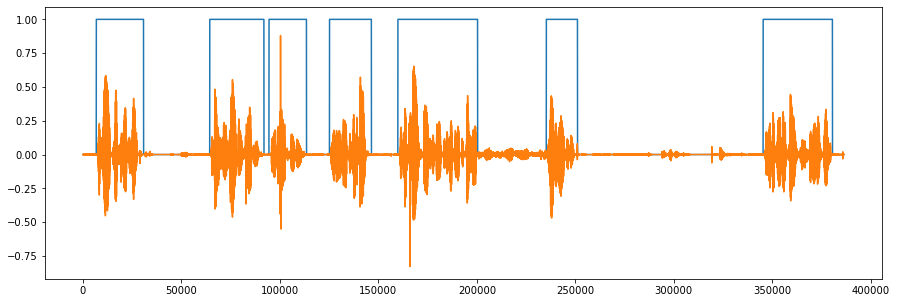

In [48]:
t = random.choice(tracklist)
signal, sr = librosa.load(t, sr=16000)
df = pd.read_csv(t.replace('.wav', '.csv'))
get_gt_plot_waveform(signal, df)

#### Frequency domain

In [27]:
import torchaudio

nfft = 1024
hop_length = 512
n_mels = 64
melspec = torchaudio.transforms.MelSpectrogram(n_fft=nfft, hop_length=hop_length, n_mels=n_mels)

In [42]:
def get_plot_spectro(audio_path, hop_length):
    waveform, sr = torchaudio.load(audio_path)
    df = pd.read_csv(audio_path.replace('.wav', '.csv'))
    mel = melspec(waveform)

    gt_plot = np.zeros((mel.shape[-1]))

    cur_frame = 0
    for i in df.index:
        utt_len = int(round(df.iloc[i].utt_time / (hop_length/sr)))
        gt_plot[cur_frame:cur_frame+utt_len] = df.iloc[i].speech  * 40
        cur_frame += utt_len
        
    plt.figure(figsize=(15, 5))
    plt.plot(gt_plot, color='red')
    plt.pcolormesh(np.log(mel.numpy()[0]))

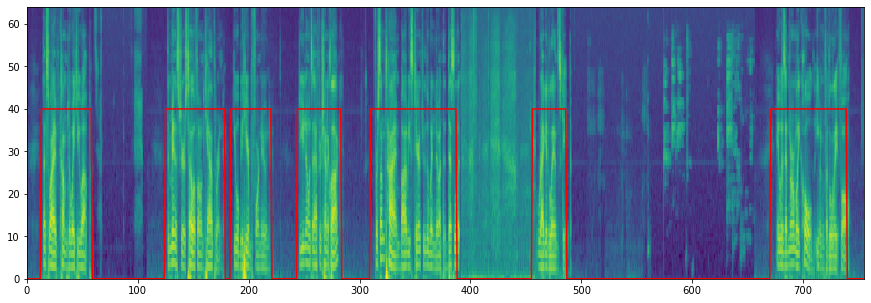

In [50]:
get_plot_spectro(t, hop_length=hop_length)

Looks OK, we can now begin the training pipeline